# 05 – Volatility trade

In this notebook we:

1. Compare the 22 day historical volatility on the trade date with the 
   option implied volatilities.
2. Construct a volatility trade (long ATM straddle) based on our view.
3. Plot the payoff of the straddle and compute its realised payoff at expiry.
4. Construct a butterfly spread using calls and the same butterfly using puts,
   and compare which is more expensive.


In [2]:
import os
import sys
from math import log, sqrt, exp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

# make sure project root is on the path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_loader import (
    load_price,
    load_calls,
    load_puts,
    load_usgg1m,
    TRADE_DATE,
    EXPIRY_DATE,
)

TRADE_DATE, EXPIRY_DATE


(Timestamp('2025-09-19 00:00:00'), Timestamp('2025-10-17 00:00:00'))

## Price series and 22-day historical volatility

In [3]:
# full price history
price_df = load_price().copy()
price_df["Date"] = pd.to_datetime(price_df["Date"])
price_df = price_df.sort_values("Date").reset_index(drop=True)

price_df["log_ret"] = np.log(price_df["PX_LAST"] / price_df["PX_LAST"].shift(1))
price_df["sigma_22d_ann"] = price_df["log_ret"].rolling(22).std() * np.sqrt(252)

# 22 day hist vol on trade date
hist_row = price_df.loc[price_df["Date"] == TRADE_DATE].iloc[0]
hist_vol_22d = float(hist_row["sigma_22d_ann"])

hist_vol_22d


0.26085264197671737

## Calls, puts, spot, rate, maturity

In [4]:
# spot on trade date
S0 = price_df.loc[price_df["Date"] == TRADE_DATE, "PX_LAST"].iloc[0]

# risk free rate
usgg = load_usgg1m().copy()
usgg["Date"] = pd.to_datetime(usgg["Date"])
r_row = usgg.loc[usgg["Date"] >= TRADE_DATE].iloc[0]
r = float(r_row["Rate"])

# time to maturity
T_days = (EXPIRY_DATE - TRADE_DATE).days
T = T_days / 365.0

calls = load_calls().copy()
puts = load_puts().copy()

# mid prices
calls["Mid"] = 0.5 * (calls["Bid"] + calls["Ask"])
puts["Mid"] = 0.5 * (puts["Bid"] + puts["Ask"])

S0, r, T


(np.float64(466.54), 0.040304, 0.07671232876712329)

## Black–Scholes call and IV solver (reused)

In [5]:
def bs_call_price(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0:
        return max(S - K, 0.0)
    d1 = (log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return S * norm.cdf(d1) - K * exp(-r * T) * norm.cdf(d2)

def implied_vol_call(price, S, K, T, r, sigma_low=1e-4, sigma_high=5.0):
    intrinsic = max(S - K * exp(-r * T), 0.0)
    if price <= intrinsic:
        return np.nan

    def f(sigma):
        return bs_call_price(S, K, T, r, sigma) - price

    try:
        return brentq(f, sigma_low, sigma_high, maxiter=100)
    except ValueError:
        return np.nan


## IV smile on trade date and comparison with 22-day hist vol

In [6]:
ivs = []

for _, row in calls.iterrows():
    K = row["Strike"]
    C_mid = row["Mid"]
    sigma = implied_vol_call(C_mid, S0, K, T, r)
    ivs.append({"Strike": K, "IV": sigma})

iv_df = pd.DataFrame(ivs).dropna().sort_values("Strike").reset_index(drop=True)
iv_df.head()


,Strike,IV
0,340,0.487144
1,350,0.461617
2,370,0.407412
3,380,0.356587
4,390,0.353236


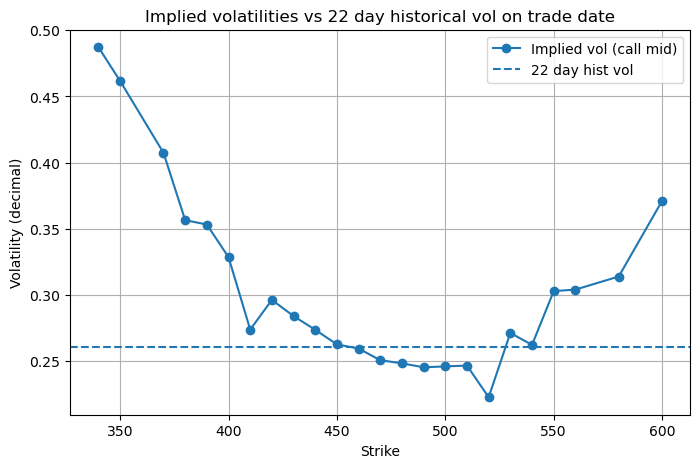

0.26085264197671737

In [7]:
plt.figure(figsize=(8,5))
plt.plot(iv_df["Strike"], iv_df["IV"], marker="o", label="Implied vol (call mid)")
plt.axhline(hist_vol_22d, linestyle="--", label="22 day hist vol")
plt.xlabel("Strike")
plt.ylabel("Volatility (decimal)")
plt.title("Implied volatilities vs 22 day historical vol on trade date")
plt.legend()
plt.grid(True)
plt.show()

hist_vol_22d


## Choose ATM strike and build long straddle

In [8]:
# ATM strike = closest K to S0
atm_idx = (calls["Strike"] - S0).abs().idxmin()
atm_K = float(calls.loc[atm_idx, "Strike"])

C_atm_mid = float(calls.loc[calls["Strike"] == atm_K, "Mid"].iloc[0])
P_atm_mid = float(puts.loc[puts["Strike"] == atm_K, "Mid"].iloc[0])

cost_straddle = C_atm_mid + P_atm_mid

atm_K, C_atm_mid, P_atm_mid, cost_straddle


(470.0, 11.9750003814697, 14.074999809265151, 26.05000019073485)

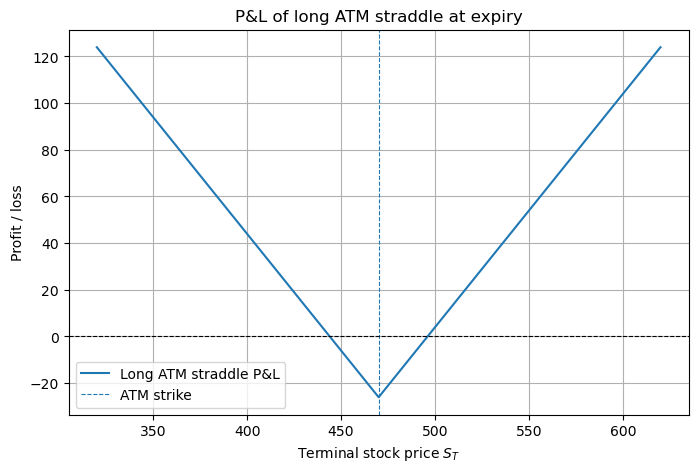

In [9]:
# payoff grid for a range of terminal prices
S_grid = np.linspace(atm_K - 150, atm_K + 150, 301)

call_payoff = np.maximum(S_grid - atm_K, 0.0)
put_payoff = np.maximum(atm_K - S_grid, 0.0)
straddle_payoff = call_payoff + put_payoff  # payoff at expiry, before cost

# profit / loss after premium
straddle_pnl = straddle_payoff - cost_straddle

plt.figure(figsize=(8,5))
plt.plot(S_grid, straddle_pnl, label="Long ATM straddle P&L")
plt.axvline(atm_K, linestyle="--", linewidth=0.8, label="ATM strike")
plt.axhline(0.0, linestyle="--", linewidth=0.8, color="black")
plt.xlabel("Terminal stock price $S_T$")
plt.ylabel("Profit / loss")
plt.title("P&L of long ATM straddle at expiry")
plt.legend()
plt.grid(True)
plt.show()


## Realised payoff of the straddle at actual ST


In [10]:
# actual terminal stock price
S_T = price_df.loc[price_df["Date"] == EXPIRY_DATE, "PX_LAST"].iloc[0]

payoff_straddle_ST = max(S_T - atm_K, 0.0) + max(atm_K - S_T, 0.0)
pnl_straddle_ST = payoff_straddle_ST - cost_straddle

S_T, payoff_straddle_ST, cost_straddle, pnl_straddle_ST


(np.float64(527.08),
 np.float64(57.08000000000004),
 26.05000019073485,
 np.float64(31.029999809265192))

## Butterfly spreads: calls vs puts

In [11]:
strikes = sorted(calls["Strike"].unique())
atm_pos = strikes.index(atm_K)

# take one strike below and one above if available
K1 = strikes[atm_pos - 1]
K2 = strikes[atm_pos]
K3 = strikes[atm_pos + 1]

K1, K2, K3


(np.int64(460), np.int64(470), np.int64(480))

In [12]:
def mid_call(K):
    return float(calls.loc[calls["Strike"] == K, "Mid"].iloc[0])

def mid_put(K):
    return float(puts.loc[puts["Strike"] == K, "Mid"].iloc[0])

C1, C2, C3 = mid_call(K1), mid_call(K2), mid_call(K3)
P1, P2, P3 = mid_put(K1), mid_put(K2), mid_put(K3)

C1, C2, C3, P1, P2, P3


(17.625,
 11.9750003814697,
 7.84999990463257,
 9.549999713897705,
 14.074999809265151,
 20.5749893188477)

In [13]:
cost_call_bfly = C1 + C3 - 2 * C2

# same structure with puts
cost_put_bfly = P1 + P3 - 2 * P2

cost_call_bfly, cost_put_bfly


(1.5249991416931685, 1.974989414215102)

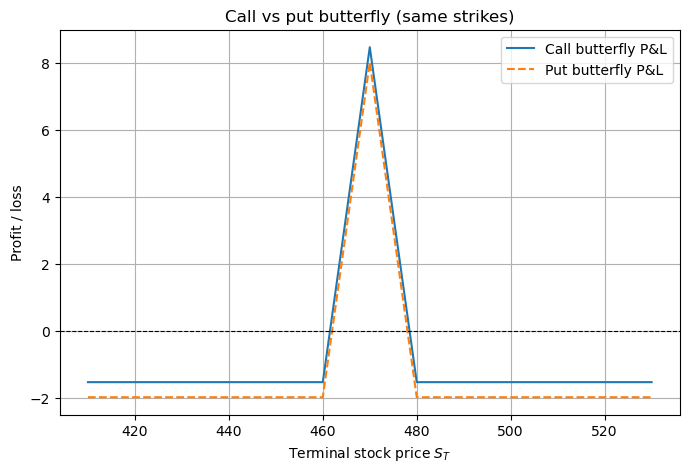

In [14]:
S_grid = np.linspace(K1 - 50, K3 + 50, 301)

def butterfly_payoff(S, K1, K2, K3):
    return (
        np.maximum(S - K1, 0.0)
        - 2 * np.maximum(S - K2, 0.0)
        + np.maximum(S - K3, 0.0)
    )

bf_payoff = butterfly_payoff(S_grid, K1, K2, K3)
bf_pnl_call = bf_payoff - cost_call_bfly
bf_pnl_put = bf_payoff - cost_put_bfly

plt.figure(figsize=(8,5))
plt.plot(S_grid, bf_pnl_call, label="Call butterfly P&L")
plt.plot(S_grid, bf_pnl_put, linestyle="--", label="Put butterfly P&L")
plt.axhline(0.0, linestyle="--", linewidth=0.8, color="black")
plt.xlabel("Terminal stock price $S_T$")
plt.ylabel("Profit / loss")
plt.title("Call vs put butterfly (same strikes)")
plt.legend()
plt.grid(True)
plt.show()
